In [1]:
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np

/mnt/kauffman/nbserver/jupyter-run-software/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


# How the data is simulated

In [17]:
from numpy.random import poisson,beta
n = 10
array_alpha_kon = np.ones((n,n))
array_alpha_koff = np.ones((n,n))
array_width_kon = np.ones((n,n))
array_width_koff = np.ones((n,n))
array_nan_kon = np.ones((n,n))
array_nan_koff = np.ones((n,n))
kon = np.logspace(-3,1,n)
koff = np.logspace(-1,2, n)
mesh_kon, mesh_koff = np.meshgrid(kon,koff,sparse = True)
array_p = np.ones((n,n,30, 140))
array_x = np.ones((n,n,30, 140))
for i in range(n):
    for k in range(n):
        for j in range(30):
            array_p[i,k,j,] = beta(kon[i], koff[k], 140)
            array_x[i,k,j,] = poisson(100*array_p[i,k,j,])

In [18]:
s = array_x.shape
expr_dict = {}
for i in range(s[0]):
    for k in range(s[1]):
        for j in range(s[2]):
            expr_dict['expr_{}_{}_{}'.format(i,k,j)] = array_x[i,k,j,]

In [24]:
#I saved the result to this .csv file and then did the inference. But did not set a seed. Woohoo.
#pd.DataFrame(expr_dict).T.to_csv('data/simulated_expr.csv')

In [2]:
sim_df = pd.read_pickle('data/simulated_expr_PL.pkl')

In [3]:
kon_group = pd.Series([idx.split('_')[1] for idx in sim_df.index], index=sim_df.index)
kon_group.name = 'kon_group'
koff_group = pd.Series([idx.split('_')[2] for idx in sim_df.index], index=sim_df.index)
koff_group.name = 'koff_group'
sim_df = sim_df.join(kon_group)
sim_df = sim_df.join(koff_group)


In [5]:
n=10
array_width_bf = np.ones((n,n))
array_width_bs = np.ones((n,n))
for kon_idx, kon_df in sim_df.groupby('kon_group'):
    for koff_idx, koff_df in kon_df.groupby('koff_group'):
        mean_width = np.mean([(p[2]-p[1])/p[0]  for p in koff_df[1] if all(~np.isnan(p))])
        if mean_width > 10000:
            mean_width = np.nan
        print(type(kon_idx))
        print(mean_width)
        print(koff_idx)
        array_width_bf[int(kon_idx), int(koff_idx)] = mean_width

<class 'str'>
2.8295616938487402
0
<class 'str'>
2.9365004588089736
1
<class 'str'>
2.9319284534719277
2
<class 'str'>
2.9797045332164043
3
<class 'str'>
2.497262957773357
4
<class 'str'>
4.660541249273583
5
<class 'str'>
nan
6
<class 'str'>
4.767803513085894
7
<class 'str'>
nan
8
<class 'str'>
nan
9
<class 'str'>
1.9515933739118618
0
<class 'str'>
2.179338039655786
1
<class 'str'>
2.314735355914266
2
<class 'str'>
2.3662529069012606
3
<class 'str'>
2.6715141619151437
4
<class 'str'>
3.2946698977429567
5
<class 'str'>
4.2084989277522045
6
<class 'str'>
4.115046419792105
7
<class 'str'>
nan
8
<class 'str'>
nan
9
<class 'str'>
1.272011849080847
0
<class 'str'>
1.3144238467188984
1
<class 'str'>
1.6226615690212556
2
<class 'str'>
1.7542267986137825
3
<class 'str'>
1.9883200955475793
4
<class 'str'>
2.6906181184973663
5
<class 'str'>
2.5711126354392038
6
<class 'str'>
nan
7
<class 'str'>
4.8861191845572165
8
<class 'str'>
nan
9
<class 'str'>
0.7750237348686639
0
<class 'str'>
0.76420211951

/mnt/kauffman/nbserver/jupyter-run-software/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/mnt/kauffman/nbserver/jupyter-run-software/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [6]:
PL_CIs = pd.read_pickle('data/SS3_cast_UMIs_concat_PL.pkl')

In [7]:
bf = pd.Series([p[0] for p in PL_CIs[0]], index=PL_CIs.index)
bs = pd.Series([p[2]/p[1] for p in PL_CIs[0]], index=PL_CIs.index)

In [11]:
from scipy.interpolate import interp1d
f_bf = interp1d( np.logspace(-3,1,100), np.linspace(0,9,100), fill_value='extrapolate')
f_bs = interp1d(100/np.logspace(-1,2, 100)[::-1],  np.linspace(0,9,100),fill_value='extrapolate')
kon = np.logspace(-3,1,n)
koff = np.logspace(-1,2, n)  

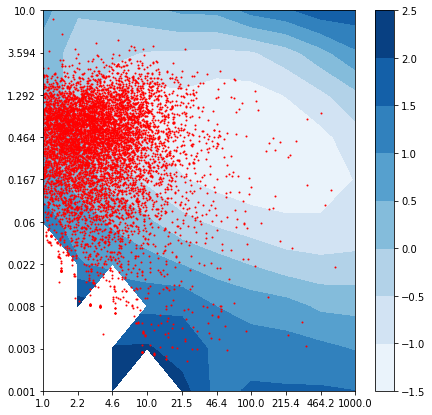

In [14]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(7,7))
plt.contourf(np.fliplr(np.log2(array_width_bf)), cmap='Blues')
plt.colorbar()
plt.scatter(f_bs(bs), f_bf(bf), s=1, c='red')
plt.yticks(np.arange(10), np.round(kon,3) )
plt.xticks(np.arange(10), np.round(100/koff[::-1],1) )
plt.xlim(0,9)
plt.savefig('figures/Fig1b.pdf')
plt.show()